## Setup

Install [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [1]:
!pip install -q -U watermark

In [2]:
!pip install -qq transformers

In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.8.1+cu101
transformers: 4.6.0



## Data Exploration

In [4]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.ERROR)

In [5]:
import pandas as pd

df_train = pd.read_table("/content/twitter-2016train-CE.txt",sep='\t|\n',names=['id','topic','score','text'])
df_dev = pd.read_table("/content/twitter-2016dev-CE.txt",sep='\t|\n',names=['id','topic','score','text'])
df_val = pd.read_table("/content/twitter-2016devtest-CE.txt",sep='\t|\n',names=['id','topic','score','text'])
df_test = pd.read_table("/content/twitter-2016test-CE.txt",sep='\t|\n',names=['id','topic','score','text'])
# merge train and dev
df_train = pd.concat([df_train,df_dev],axis=0,ignore_index=True)

df_train = df_train[~df_train['text'].isin(['Not Available'])]
df_val = df_val[~df_val['text'].isin(['Not Available'])]
df_test = df_test[~df_test['text'].isin(['Not Available'])]

df_train.head()

,id,topic,score,text
0,628949369883000832,@microsoft,-1,dear @Microsoft the newOoffice for Mac is grea...
1,628976607420645377,@microsoft,-2,@Microsoft how about you make a system that do...
4,629186282179153920,@microsoft,0,If I make a game as a #windows10 Universal App...
5,629226490152914944,@microsoft,1,"Microsoft, I may not prefer your gaming branch..."
6,629345637155360768,@microsoft,-1,@MikeWolf1980 @Microsoft I will be downgrading...


Dataset description.

In [6]:
train_samples = df_train.shape[0]
val_samples = df_val.shape[0]
test_samples = df_test.shape[0]

print("Sample Number of train: ", df_train.shape[0])
print("Sample Number of val: ", df_val.shape[0])
print("Sample Number of test: ", df_test.shape[0])

Sample Number of train:  6452
Sample Number of val:  1622
Sample Number of test:  12443


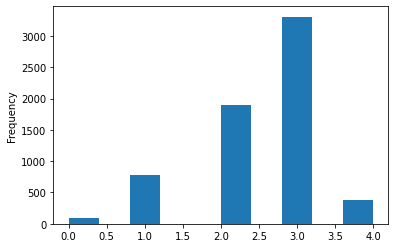

In [7]:
def to_sentiment(rating):
  rating = int(rating)
  if rating == -2:
    return 0
  elif rating == -1:
    return 1
  elif rating == 0:
    return 2
  elif rating == 1:
    return 3
  else: 
    return 4

df_train['sentiment'] = df_train.score.apply(to_sentiment)
df_val['sentiment'] = df_val.score.apply(to_sentiment)
df_test['sentiment'] = df_test.score.apply(to_sentiment)
df_train.sentiment.plot.hist()

Max length:  44


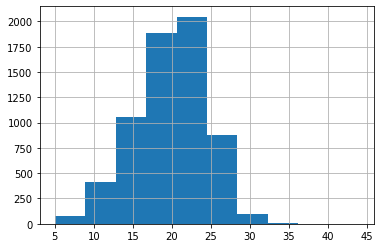

In [8]:
lengths = df_train["text"].apply(lambda x : len(x.split(" ")))
lengths.hist()
print("Max length: ", lengths.max())

## Data Preprocessing
Load a pre-trained BERT model and the corresponding tokenizer, which converts text data into tokens. 


In [9]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [10]:
import transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

From above we can got that most text in the dataset contain less than around 30 tokens, but let us choose a maximum length of 50.

In [11]:
MAX_LEN = 50

## Building the dataset

In [12]:
from torch.utils.data import Dataset

class TwitterDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    text = str(self.texts[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True,
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [13]:
from torch.utils.data import DataLoader

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TwitterDataset(
    texts=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [14]:
BATCH_SIZE = 64

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

An example batch from training data loader:

In [15]:
import torch

data = next(iter(train_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64])


Load the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build sentiment classifier on top of it. Load the model using:

In [16]:
from transformers import BertModel
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
import torch.nn as nn

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(output.pooler_output)
    return self.out(output)

In [18]:
model = SentimentClassifier(5)
device = torch.device('cuda:0')
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [20]:
import torch.nn.functional as F

F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2519, 0.1803, 0.1436, 0.2248, 0.1994],
        [0.1414, 0.3559, 0.2395, 0.1263, 0.1369],
        [0.2141, 0.2440, 0.1367, 0.2193, 0.1860],
        [0.2712, 0.2394, 0.0930, 0.2025, 0.1939],
        [0.2177, 0.2354, 0.1173, 0.2739, 0.1556],
        [0.1577, 0.1666, 0.2105, 0.2459, 0.2192],
        [0.2096, 0.1308, 0.2504, 0.2831, 0.1262],
        [0.2418, 0.1685, 0.1186, 0.3217, 0.1494],
        [0.2140, 0.2644, 0.1078, 0.2887, 0.1251],
        [0.2036, 0.1338, 0.1573, 0.3695, 0.1359],
        [0.1684, 0.2406, 0.1589, 0.2616, 0.1704],
        [0.2088, 0.1710, 0.1654, 0.3368, 0.1180],
        [0.1168, 0.3063, 0.1634, 0.2343, 0.1792],
        [0.2067, 0.2922, 0.2015, 0.2032, 0.0963],
        [0.2247, 0.2960, 0.1528, 0.1561, 0.1704],
        [0.2286, 0.2127, 0.1303, 0.2633, 0.1651],
        [0.1748, 0.2371, 0.2163, 0.2854, 0.0864],
        [0.1916, 0.3477, 0.1250, 0.2078, 0.1279],
        [0.2585, 0.2120, 0.1943, 0.2508, 0.0844],
        [0.2709, 0.2681, 0.1005, 0.1593, 0.2011],


## Training

To train the model, we will use the AdamW optimizer and a linear learning-rate scheduler with no warmup steps, along with the cross-entropy loss.

In [21]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 50

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [22]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:    
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    #print(loss)
    correct_predictions += (preds == targets).float().sum()
    
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [23]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  
  for d in data_loader: 
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += (preds == targets).float().sum()
    losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:

from collections import defaultdict
import numpy as np
import warnings
 
warnings.filterwarnings('ignore')

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, train_samples)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, val_samples)

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc >= best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/50
----------
Train loss 1.2214831084308058 accuracy 0.4986050836949783
Val   loss 1.244799643754959 accuracy 0.5456226880394575

Epoch 2/50
----------
Train loss 1.0451760929409821 accuracy 0.5641661500309981
Val   loss 1.1000590737049396 accuracy 0.5431565967940813

Epoch 3/50
----------
Train loss 0.8299141340326555 accuracy 0.6611903285802851
Val   loss 1.1796852098061488 accuracy 0.5573366214549939

Epoch 4/50
----------
Train loss 0.656120363143411 accuracy 0.7376007439553627
Val   loss 1.2669777021958277 accuracy 0.5431565967940813

Epoch 5/50
----------
Train loss 0.5740956996041949 accuracy 0.7816181029138252
Val   loss 1.847510814666748 accuracy 0.44204685573366215

Epoch 6/50
----------
Train loss 0.4175549289303841 accuracy 0.8471791692498449
Val   loss 1.7350929975509644 accuracy 0.5382244143033292

Epoch 7/50
----------
Train loss 0.2744139474954936 accuracy 0.9032858028518288
Val   loss 1.9189361746494586 accuracy 0.5524044389642417

Epoch 8/50
----------
Train l

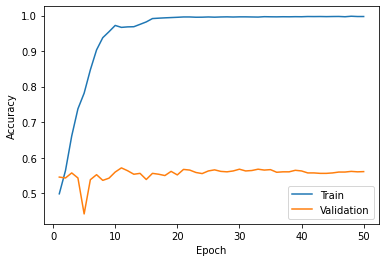

In [26]:
import matplotlib.pyplot as plt

epochNum = np.arange(1,51)
train_acc = history['train_acc']
val_acc = history['val_acc']
plt.plot(epochNum, train_acc, label='Train')
plt.plot(epochNum, val_acc, label='Validation')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy") 
plt.legend()

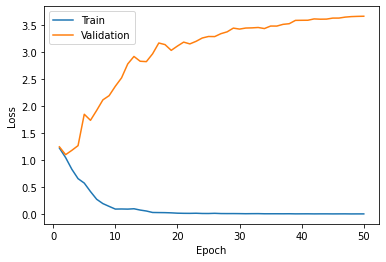

In [27]:
train_loss = history['train_loss']
val_loss = history['val_loss']
plt.plot(epochNum, train_loss, label='Train')
plt.plot(epochNum, val_loss, label='Validation')
plt.xlabel("Epoch") 
plt.ylabel("Loss") 
plt.legend()

## Evaluation

In [28]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      #texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      #probs = F.softmax(outputs, dim=1)

      #review_texts.extend(texts)
      predictions.extend(preds)
      #prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  #prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  #return review_texts, predictions, prediction_probs, real_values
  return predictions, real_values

In [29]:
model.load_state_dict(torch.load('best_model_state.bin'))
y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [33]:
correct_predictions = (y_pred == y_test).float().sum()
test_acc = correct_predictions.double() / test_samples
print("Test Accuracy: ", test_acc.item())

Test Accuracy:  0.5339548340432372


[[   1   34   25   11    0]
 [   3  210  710  348    1]
 [   1  181 2212 3587   16]
 [   1   31  480 4166  171]
 [   0    2    6  191   55]]


Text(0.5, 0, 'Predicted Sentiment')

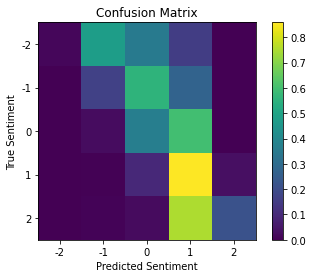

In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)
print(cm)
cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
num_local = np.array(range(5))    
plt.xticks(num_local, [-2,-1,0,1,2])
plt.yticks(num_local, [-2,-1,0,1,2])
plt.ylabel('True Sentiment')    
plt.xlabel('Predicted Sentiment')